<a href="https://colab.research.google.com/github/samueleborgognoni/kmeans_nn_ILF_london_smart_meters/blob/main/2_data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data preparation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # <- activate to use Google Colab

drive_folder_path = '/content/drive/MyDrive/-Career📚/_UNIVERSITY/__Macchine_ed_azionamenti_elettrici/_Progetto_MAE/mae_proj/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import cleaned dataset
df = pd.read_csv(drive_folder_path + 'data/df_cleaned.csv')
df.shape


(22370778, 3)

In [ ]:
# Display the header of DF
df.head(5)


,LCLid,tstp,energy(kWh/hh)
0,MAC000002,2012-10-12 00:30:00,0.0
1,MAC000002,2012-10-12 01:00:00,0.0
2,MAC000002,2012-10-12 01:30:00,0.0
3,MAC000002,2012-10-12 02:00:00,0.0
4,MAC000002,2012-10-12 02:30:00,0.0


In [ ]:
# Count the number of single LCLid (housholds)
df['LCLid'].nunique()

750

In [ ]:
# Count the number of samples for a given ID
id_count = df['LCLid'].value_counts() # type: pd.series
print(f"{id_count[:5]}\n{'-'*35}")

# Evaluate the variance of the number of samples for each ID
print(f"ID_count MEAN: {int(id_count.mean()/48)} days of samples")
print(f"ID_count STD: {int(id_count.std()/48)} days of samples")
print(f"ID_count MAX: {int(max(id_count/48))} days of samples \t -- ID: {id_count.argmax()}° household")
print(f"ID_count MIN: {round(min(id_count/48),2)} days of samples \t -- ID: {id_count.argmin()}° household")

LCLid
MAC000155    39705
MAC000193    39480
MAC000194    39462
MAC000246    39245
MAC000017    39087
Name: count, dtype: int64
-----------------------------------
ID_count MEAN: 621 days of samples
ID_count STD: 116 days of samples
ID_count MAX: 827 days of samples 	 -- ID: 0° household
ID_count MIN: 0.94 days of samples 	 -- ID: 749° household


In [ ]:
print(f"Number of NaN energy values: {df['energy(kWh/hh)'].isna().sum()}")

Number of NaN energy values: 748


### NaN imputer

In [ ]:
# NAN IMPUTER with SimpleImputer (for datasets with only 1 feature)

# User_guide: https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df['energy(kWh/hh)'] = imp.fit_transform(np.array(df['energy(kWh/hh)']).reshape(-1,1))

print(f"Check -- number of NaN energy values (must be zero): {df['energy(kWh/hh)'].isna().sum()}")

Check -- number of NaN energy values (must be zero): 0


### Outlier detection

Energy mean: 0.291 kWh/hh
Energy std: 0.384 kWh/hh
-------------------------
0.25 quantile: 0.078 kWh/hh
0.75 qunatile: 0.338 kWh/hh
-------------------------
Interquantile range (IQR): 0.26 kWh/hh


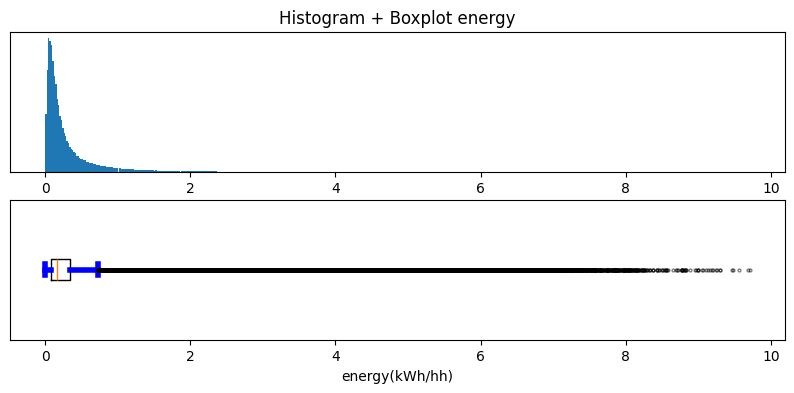

              LCLid                 tstp  energy(kWh/hh)
37        MAC000002  2012-10-12 19:30:00           0.886
66        MAC000002  2012-10-13 10:00:00           0.915
67        MAC000002  2012-10-13 10:30:00           0.933
84        MAC000002  2012-10-13 19:00:00           0.918
131       MAC000002  2012-10-14 18:30:00           1.085
...             ...                  ...             ...
22370701  MAC005387  2014-02-26 10:00:00           1.295
22370711  MAC005387  2014-02-26 15:00:00           1.026
22370712  MAC005387  2014-02-26 15:30:00           1.071
22370753  MAC005387  2014-02-27 12:00:00           1.362
22370754  MAC005387  2014-02-27 12:30:00           0.935

[2109267 rows x 3 columns]


In [ ]:
# Calculate the quantile
# IQR: Interquartile Range
Q1 = df['energy(kWh/hh)'].quantile(0.25)
Q3 = df['energy(kWh/hh)'].quantile(0.75)
IQR = Q3 - Q1

print(f"Energy mean: {round(df['energy(kWh/hh)'].mean(),3)} kWh/hh")
print(f"Energy std: {round(df['energy(kWh/hh)'].std(),3)} kWh/hh")
print('-'*25)
print(f"0.25 quantile: {Q1} kWh/hh")
print(f"0.75 qunatile: {Q3} kWh/hh")
print('-'*25)
print(f"Interquantile range (IQR): {IQR} kWh/hh")


# HISTOGRAM + BOXPLOT
plt.figure(figsize=(10, 4))
# Hist
plt.subplot(2, 1, 1)
plt.hist(df['energy(kWh/hh)'], bins=500, orientation='vertical', density=True)
plt.yticks([])
plt.title("Histogram + Boxplot energy")
# Boxplot
plt.subplot(2, 1, 2)
plt.boxplot(df['energy(kWh/hh)'],
            orientation='horizontal',
            whiskerprops=dict(color='blue', linewidth=4),
            capprops=dict(color='blue', linewidth=4),
            flierprops=dict(markersize=2, alpha=0.5))
plt.yticks([])
plt.xlabel("energy(kWh/hh)")
plt.show()


# Outlier condition for detection
outliers_1 = df[(df['energy(kWh/hh)'] < Q1 - 1.5*IQR) | (df['energy(kWh/hh)'] > Q3 + 1.5*IQR)]
print(outliers_1)


In [ ]:
print("IQR outliers detection method:")
print(f"Number of outliers: {len(outliers_1)}\t({round(len(outliers_1)/len(df)*100,2)}%)")
print('-'*35)
print(f"Number of smart meters with outliers: {len(outliers_1['LCLid'].unique())}")
print('-'*35)
print(f"ID of the 5 smart meter with more outliers: {outliers_1['LCLid'].value_counts().head(5)}")



IQR outliers detection method:
Number of outliers: 2109267	(9.43%)
-----------------------------------
Number of smart meters with outliers: 742
-----------------------------------
ID of the 5 smart meter with more outliers: LCLid
MAC004179    31081
MAC000557    30595
MAC005406    22965
MAC000985    22658
MAC004593    22490
Name: count, dtype: int64


In [ ]:
# New outlier detection method: quantile approach (more suitable for long-tailed distributions)
low_bound, high_bound = df['energy(kWh/hh)'].quantile([0.01, 0.99])
condition_2 = (df['energy(kWh/hh)'] < low_bound) | (df['energy(kWh/hh)'] > high_bound)
outliers_2 = df[condition_2]

perc_outliers_2 = round(len(outliers_2)/len(df)*100,2)

print("1°-99° percentile outliers detection method:")
print(outliers_2)
print('-'*35)
print(f"Number of outliers: {len(outliers_2)}\t({perc_outliers_2}%)")
print('-'*35)
print(f"Number of smart meters with outliers: {len(outliers_2['LCLid'].unique())}")
print('-'*35)
print(f"ID of the 5 smart meter with more outliers: {outliers_2['LCLid'].value_counts().head(5)}")

1°-99° percentile outliers detection method:
              LCLid                 tstp  energy(kWh/hh)
0         MAC000002  2012-10-12 00:30:00           0.000
1         MAC000002  2012-10-12 01:00:00           0.000
2         MAC000002  2012-10-12 01:30:00           0.000
3         MAC000002  2012-10-12 02:00:00           0.000
4         MAC000002  2012-10-12 02:30:00           0.000
...             ...                  ...             ...
22367491  MAC005387  2013-12-21 13:00:00           2.420
22367496  MAC005387  2013-12-21 15:30:00           1.960
22369215  MAC005387  2014-01-26 11:00:00           1.886
22369218  MAC005387  2014-01-26 12:30:00           2.001
22370240  MAC005387  2014-02-16 19:30:00           1.972

[431778 rows x 3 columns]
-----------------------------------
Number of outliers: 431778	(1.93%)
-----------------------------------
Number of smart meters with outliers: 636
-----------------------------------
ID of the 5 smart meter with more outliers: LCLid
MAC005313

### Outlier imputation

In [ ]:
def plot_outliers(outliers_2:pd.DataFrame):
  # Plot the outliers

  outliers_pre = outliers_2

  plt.figure(figsize=(10, 4))

  plt.subplot(2, 1, 1)
  plt.plot(np.arange(len(outliers_pre['energy(kWh/hh)'])), outliers_pre['energy(kWh/hh)'])
  plt.ylim((high_bound,max(outliers_pre['energy(kWh/hh)'])))
  plt.ylabel('energy(kWh/hh)')
  plt.gca().yaxis.set_label_position("right")

  plt.title('Outliers before the imputation')

  plt.subplot(2, 1, 2)
  plt.plot(np.arange(len(outliers_pre['energy(kWh/hh)'])), outliers_pre['energy(kWh/hh)'])
  plt.ylim((min(outliers_pre['energy(kWh/hh)']), low_bound))
  plt.ylabel('energy(kWh/hh)')
  plt.gca().yaxis.set_label_position("right")
  plt.xlabel('Samples')

  plt.show()

# plot_outliers(outliers_2)

In [ ]:
df_clean = df.copy()

# Turn all the outliers into NaN values
df_clean.loc[condition_2, 'energy(kWh/hh)'] = np.nan

# Check
print(f"Check Number of NaN energy values (must be > {len(outliers_2)}): {df_clean['energy(kWh/hh)'].isna().sum()}")

# Use SimpleImputer to impute NaN values (outliers) wit the mean of the energy
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df_clean['energy(kWh/hh)'] = imp.fit_transform(np.array(df_clean['energy(kWh/hh)']).reshape(-1,1))


Check Number of NaN energy values (must be > 431778): 431778


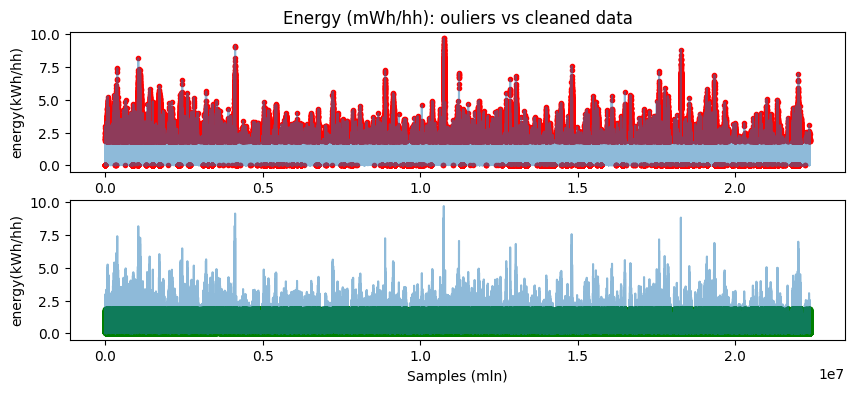

In [ ]:
def plot_energy(df: pd.DataFrame, legend=False):
  '''Plot energy and highlight the detected outliers
  (legend = True takes some time)'''

  plt.figure(figsize=(10, 4))
  plt.subplot(2, 1, 1)
  plt.plot(df['energy(kWh/hh)'], label='energy (kWh/hh)',alpha=0.5)
  # plot outliers
  plt.scatter(
      df.index[condition_2],
      df.loc[condition_2, 'energy(kWh/hh)'],
      color='red',
      marker='.',
      label=f'outliers ({perc_outliers_2}%)')
  plt.ylabel('energy(kWh/hh)')
  plt.title('Energy (mWh/hh): ouliers vs cleaned data')

  if legend:
    plt.legend()

  plt.subplot(2, 1, 2)
  plt.plot(df['energy(kWh/hh)'], label='energy (kWh/hh)',alpha=0.5)
  # plot imputed data
  plt.scatter(
      df_clean.index,
      df_clean['energy(kWh/hh)'],
      color='green',
      marker='.',
      label='cleaned/imputed data')
  plt.ylabel('energy(kWh/hh)')
  plt.xlabel('Samples (mln)')

  if legend:
    plt.legend()
  plt.show()


plot_energy(df,legend=False)

### Feature extraction

In [ ]:
def get_df_hourly(df:pd.DataFrame):
  '''Create a new pd.DataFrame with the energy measurementents
  resampled every hour'''
  # Convert timestamps from str to datetime
  df['tstp'] = pd.to_datetime(df['tstp'])
  # Resample the df
  df_hourly = (
      df
      .set_index('tstp')
      .groupby('LCLid')
      .resample('1h')['energy(kWh/hh)']
      .sum()
      .reset_index()
  )
  return df_hourly.rename(columns={'energy(kWh/hh)': 'energy(kWh)'})


In [ ]:
def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["hour"] = df["tstp"].dt.hour
    df["weekday"] = df["tstp"].dt.weekday  # Monday=0 ... Sunday=6
    df["date"] = df["tstp"].dt.date
    df["week"] = df["tstp"].dt.isocalendar().week
    df["month"] = df["tstp"].dt.month
    return df


def extract_features(df_hourly: pd.DataFrame):
  '''Extract new features to enchance the performance of the clustering algorithm'''
  df = df_hourly.copy()

  # Time features ---------

  df["hour"] = df["tstp"].dt.hour
  df["weekday"] = df["tstp"].dt.weekday  # Mon=0 ... Sun=6
  df["date"] = df["tstp"].dt.date
  df["week"] = df["tstp"].dt.isocalendar().week
  df["month"] = df["tstp"].dt.month


  # BASIC FEATURES ---------
  features = df.groupby("LCLid").agg(
      TKWh=("energy(kWh)", "sum"),
      Avg_hourly=("energy(kWh)", "mean")
  )

  # DAILY / WEEKLY / MONTHLY AVERAGES ---------
  daily = (
      df.groupby(["LCLid", "date"])["energy(kWh)"]
        .sum()
        .groupby("LCLid")
        .mean()
  )

  weekly = (
      df.groupby(["LCLid", "week"])["energy(kWh)"]
        .sum()
        .groupby("LCLid")
        .mean()
  )

  monthly = (
      df.groupby(["LCLid", "month"])["energy(kWh)"]
        .sum()
        .groupby("LCLid")
        .mean()
  )

  features["Avg_daily"] = daily
  features["Avg_weekly"] = weekly
  features["Avg_monthly"] = monthly

  # WEEKDAY FEATURES ---------
  weekday_avg = (
      df.groupby(["LCLid", "weekday"])["energy(kWh)"]
        .mean()
        .unstack()
  )

  weekday_avg.columns = [
      "Avg_Mon", "Avg_Tue", "Avg_Wed",
      "Avg_Thu", "Avg_Fri", "Avg_Sat", "Avg_Sun"
  ]

  features = features.join(weekday_avg)

  features["Avg_weekend"] = features[["Avg_Sat", "Avg_Sun"]].mean(axis=1)
  features["Avg_workday"] = features[
      ["Avg_Mon", "Avg_Tue", "Avg_Wed", "Avg_Thu", "Avg_Fri"]
  ].mean(axis=1)

  # DAILY TIME PERIODS ---------
  def period(h):
      if 7 <= h <= 9:
          return "Avg_EM"    # Early Morning
      elif 10 <= h <= 13:
          return "Avg_M"     # Morning
      elif 14 <= h <= 17:
          return "Avg_EAN"   # Early Afternoon
      elif 18 <= h <= 21:
          return "Avg_LAN"   # Late Afternoon
      else:
          return "Avg_N"     # Night

  df["period"] = df["hour"].apply(period)

  period_avg = (
      df.groupby(["LCLid", "period"])["energy(kWh)"]
        .mean()
        .unstack()
  )

  features = features.join(period_avg)

  return features.reset_index()



In [ ]:
# Create a new df with resampled measures
df_hourly = get_df_hourly(df)

# Create a new df with all the extracted features for each household
df_prepared = extract_features(df_hourly)

# diplay a range of values of the new dataframe
df_prepared[100:200]


,LCLid,TKWh,Avg_hourly,Avg_daily,Avg_weekly,Avg_monthly,Avg_Mon,Avg_Tue,Avg_Wed,Avg_Thu,Avg_Fri,Avg_Sat,Avg_Sun,Avg_weekend,Avg_workday,Avg_EAN,Avg_EM,Avg_LAN,Avg_M,Avg_N
100,MAC000897,3419.371636,0.212133,5.080790,65.757147,284.947636,0.170844,0.202270,0.193397,0.205240,0.224304,0.203617,0.285307,0.244462,0.199211,0.253972,0.213665,0.292887,0.264044,0.133988
101,MAC000902,13464.598639,0.835325,20.006833,258.934589,1122.049887,0.772327,0.705769,0.699226,0.714332,0.844940,1.062318,1.048399,1.055359,0.747319,0.946399,0.918861,1.161941,0.857988,0.602688
102,MAC000931,2663.667637,0.166240,3.981566,51.224378,221.972303,0.164243,0.163828,0.149655,0.162451,0.155118,0.149678,0.218943,0.184311,0.159059,0.305824,0.151808,0.173537,0.249443,0.068687
103,MAC000948,8586.580637,0.535958,12.834949,165.126551,715.548386,0.537857,0.514287,0.492929,0.534465,0.517772,0.599718,0.555267,0.577493,0.519462,0.519006,0.481117,0.690548,0.598413,0.465230
104,MAC000957,15172.029637,0.947009,22.678669,291.769801,1264.335803,0.879314,0.933801,0.944754,0.927266,0.928329,0.986182,1.029726,1.007954,0.922693,1.063672,1.112300,1.630557,0.917265,0.549157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,MAC001873,7539.440637,0.498871,11.948400,144.989243,628.286720,0.535022,0.507727,0.505470,0.470780,0.523344,0.490992,0.458843,0.474918,0.508469,0.594354,0.509939,0.976663,0.479865,0.248578
196,MAC001893,11481.434635,0.759857,18.195617,220.796820,956.786220,0.732177,0.754048,0.768906,0.769470,0.768419,0.708073,0.817945,0.763009,0.758604,0.963661,0.538766,1.360322,0.805316,0.455465
197,MAC001897,4923.239637,0.325848,7.802282,94.677685,410.269970,0.326379,0.316780,0.317040,0.303557,0.293539,0.413992,0.309486,0.361739,0.311459,0.526907,0.378915,0.422260,0.437582,0.126147
198,MAC001928,5530.919637,0.366626,8.779238,106.363839,460.909970,0.383560,0.337629,0.342777,0.371936,0.370596,0.364188,0.395725,0.379957,0.361300,0.392571,0.339299,0.485010,0.407724,0.293238


In [ ]:
# Save the full prepared dataset into a new .csv file

# df_prepared.to_csv(drive_folder_path + 'data/df_extracted.csv', index=False) # uncomment to save the just prepared dataframe into .csv file